In [2]:
from __future__ import print_function

from collections import Counter
import itertools as it

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics

In [3]:
df = pd.read_pickle("data/results/all_vs_all.pkl")
df.columns = [u'Tile A', u'Tile B', u'Precision', u'Recall', u'AUC']

from scipy.spatial import distance

POSITIONS = {
    'b206': (13, 8),
    'b214': (13, 0),
    'b216': (12, 12),
    'b220': (12, 8),
    'b228': (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    'b356': (2, 12),
    'b360': (2, 8),
    'b396': ( 0, 0),
}


def get_dis(row):
    ta, tb = (row["Tile A"], row["Tile B"])
    pa, pb = map(float, POSITIONS[ta]), map(float, POSITIONS[tb])
    return distance.cityblock(pa, pb)

df["Distancia"] = df.apply(get_dis, axis=1)

In [4]:
all_tiles = list(set(list(df["Tile A"].values) + list(df["Tile B"].values)))
all_tiles

freq = dict(Counter(df["Tile A"].values).most_common())
for t in all_tiles:
    if t not in freq:
        freq[t] = (max(freq.values()) + 100) * -1

In [5]:
all_tiles = sorted(all_tiles, key=freq.get)
all_tiles

['b396',
 'b360',
 'b356',
 'b278',
 'b277',
 'b264',
 'b263',
 'b262',
 'b261',
 'b248',
 'b247',
 'b234',
 'b228',
 'b220',
 'b216',
 'b214',
 'b206']

In [6]:
def table(attr, use_distance=False):
    rows = []
    for ta in all_tiles:
        row = [ta]
        for tb in all_tiles:
            pa, pb = POSITIONS[ta], POSITIONS[tb]
            d = distance.cityblock(pa, pb) if use_distance else 1
            try:
                flt = (df["Tile A"] == ta) & (df["Tile B"] == tb)
                v = df[flt][attr].values[0] * d
            except:
                v = np.nan
            row.append(v)
        if len(set(row)) != 2:
            rows.append(row)
    tab = pd.DataFrame(rows, columns=["Tile A"] + all_tiles).set_index("Tile A")
    tab = tab.dropna(axis=1, how='all')
    return tab

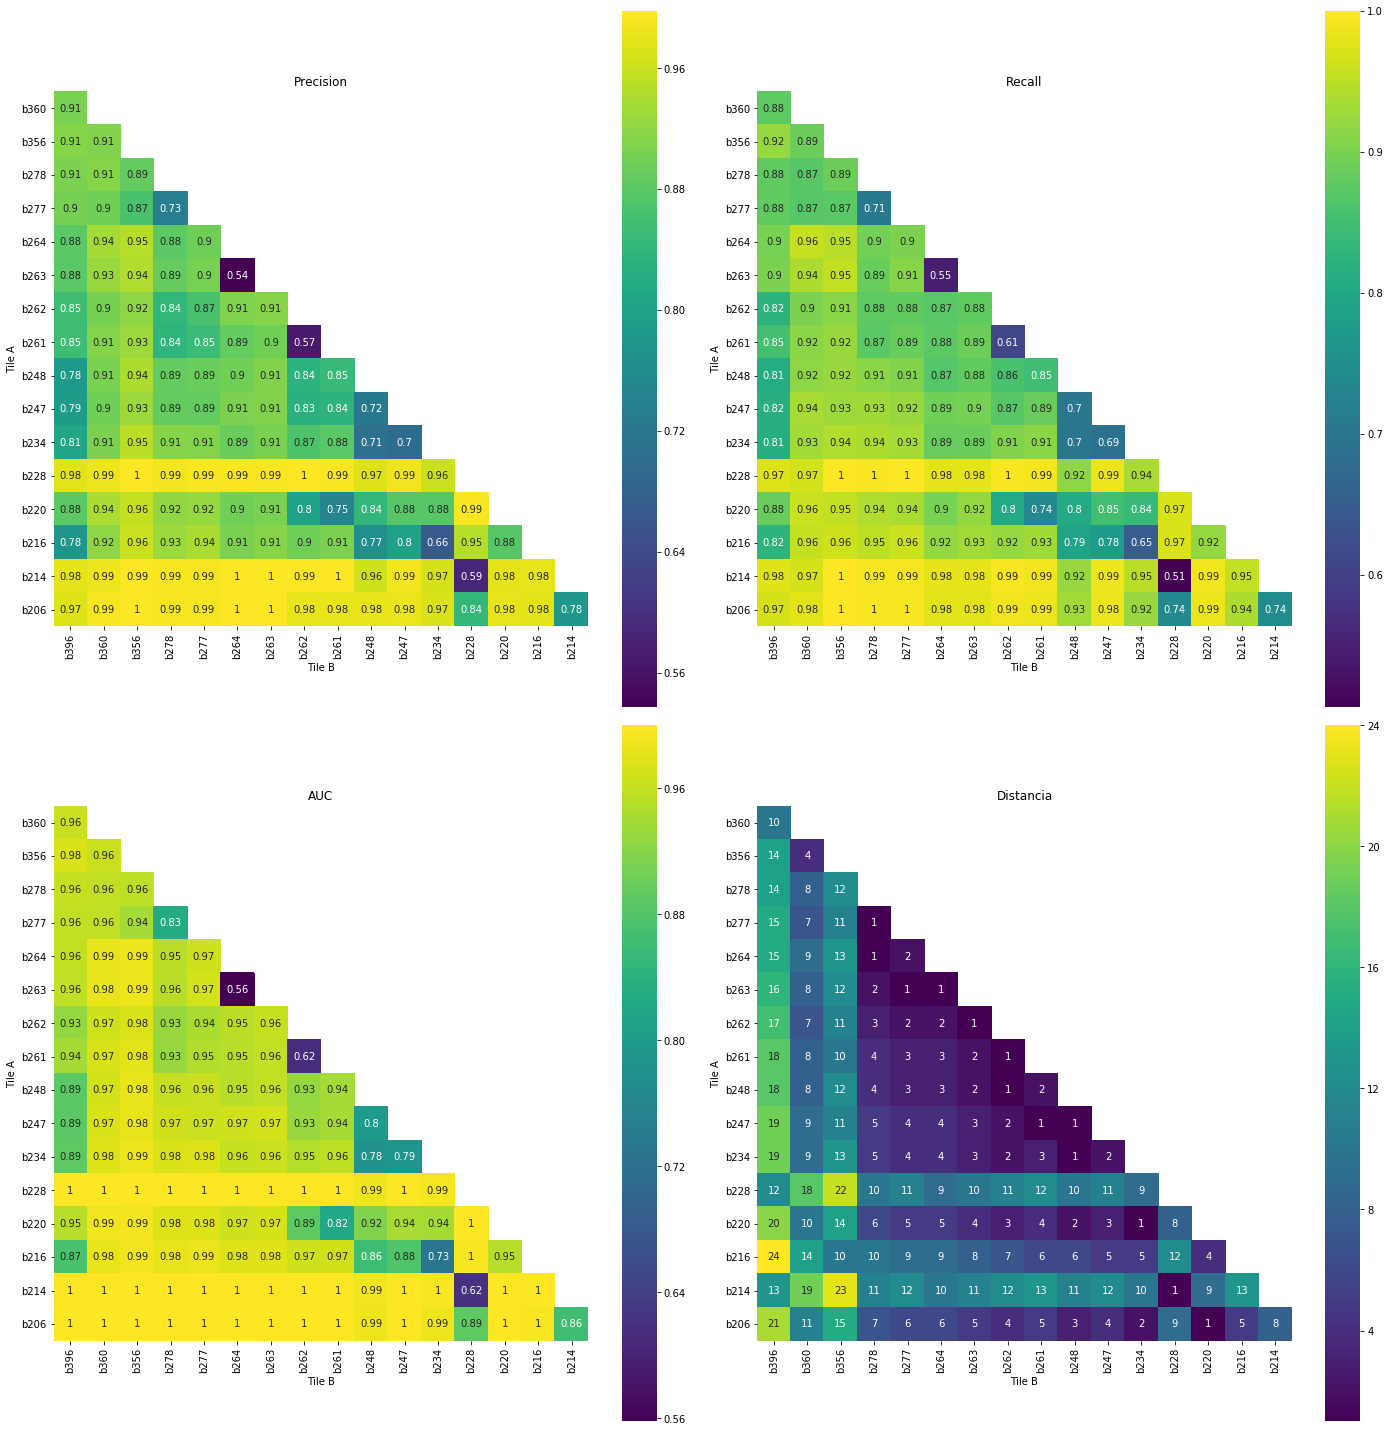

In [13]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))

ax, name = axes[0][0], "Precision"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[0][1], "Recall"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][0], "AUC"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][1], "Distancia"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")


plt.tight_layout()
plt.savefig("plots/all_vs_all.pdf")

plt.show()

In [8]:
print(df.groupby("Distancia").median().to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
{} &  Precision &  Recall &   AUC \\
Distancia &            &         &       \\
\midrule
1.0       &      0.836 &   0.840 & 0.929 \\
2.0       &      0.880 &   0.880 & 0.953 \\
3.0       &      0.887 &   0.887 & 0.953 \\
4.0       &      0.899 &   0.917 & 0.964 \\
5.0       &      0.914 &   0.938 & 0.976 \\
6.0       &      0.921 &   0.942 & 0.976 \\
7.0       &      0.900 &   0.912 & 0.967 \\
8.0       &      0.915 &   0.916 & 0.974 \\
9.0       &      0.936 &   0.935 & 0.985 \\
10.0      &      0.965 &   0.956 & 0.991 \\
11.0      &      0.989 &   0.979 & 0.999 \\
12.0      &      0.977 &   0.974 & 0.998 \\
13.0      &      0.979 &   0.954 & 0.997 \\
14.0      &      0.917 &   0.938 & 0.980 \\
15.0      &      0.901 &   0.899 & 0.960 \\
16.0      &      0.880 &   0.902 & 0.957 \\
17.0      &      0.855 &   0.824 & 0.928 \\
18.0      &      0.855 &   0.853 & 0.941 \\
19.0      &      0.808 &   0.816 & 0.890 \\
20.0      &      0.882 &   0.885 & 0.953 \\

In [10]:
more = [("Precision", 'count')] + list(it.product(["Precision", "Recall", "AUC"]))
print(more)

[('Precision', 'count'), ('Precision',), ('Recall',), ('AUC',)]


In [11]:
df.groupby("Distance").describe()[more]

KeyError: 'Distance'

In [ ]:
sns.boxplot(data=df["Precision Recall AUC".split()], orient="h", boxprops=dict(alpha=.5))
plt.tight_layout()
plt.savefig("plots/all_vs_all_boxplot.pdf")
plt.show()